In [7]:
import pandas as pd
import os

First step is to create the connection to Databricks

In [1]:
# Connect to Databricks
from databricks import sql
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession
import pandas as pd

# Load the environment variables
load_dotenv()

# Set the connection
connection =  sql.connect(server_hostname = os.getenv("DATABRICKS_SERVER_HOSTNAME"),
                 http_path       = os.getenv("DATABRICKS_HTTP_PATH"),
                 access_token    = os.getenv("PYTHON_ACCESS_TOKEN"))

cursor = connection.cursor()


# Start spark session
spark = SparkSession.builder \
    .appName("mkt_analysis_2024") \
    .getOrCreate()

def get_df_from_databricks(query):
    # Execute the query
    cursor.execute(query)
    # Get the result
    result = cursor.fetchall()
    # Get the column names
    columns = [desc[0] for desc in cursor.description]
    # Create a pandas DataFrame
    df = pd.DataFrame(result, columns=columns)
    return df


24/05/29 07:36:54 WARN Utils: Your hostname, Bernardos-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.68.117 instead (on interface en0)
24/05/29 07:36:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/29 07:36:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


A bit about how the data is structured at Metaloop. We essentially have these sources of trasactional material data:

 - Cart items
    - These are the materials that compose a transaction (stored in the orders object). Each order is associated with two accounts, a seller and a buyer. Therefore, the lowest granularity data here will be cart item level data with data from the orders joined
 - Opportunity materials
    - These paly a similar role as cart items, but on the opportunity level (prior to an order being put forward)
 - Conditions (Contract materials)

 

In [11]:
# Read the query from the query file    
queries_path = os.path.join(os.getcwd(), "queries/")

# Read the cart items query
query = open(queries_path + "cart_items.sql").read()

# Get cart_items
cart_items = get_df_from_databricks(query)

In [2]:
# Read the query from the query file    
queries_path = os.path.join(os.getcwd(), "queries/")

# Read the contract materials query
query = open(queries_path + "contract_materials.sql").read()

# Get cart_items
contract_materials = get_df_from_databricks(query)

# Save the contract materials df as a csv
contract_materials.to_csv("data_git/contract_materials.csv", index=False)

Analyse the cart items

In [154]:
# Print the dataset
cart_items

cart_items.to_csv("data_git/cart_items.csv", index=False)

## Simple bag of words model

With a simple bag of words model, we try to extract features from the alias, material and formula fields. Our target variable is the variable product_id, which is a class corresponding to the underlying product related to the material. This is encoded by the class in fk_material column.
We will also only use the aliases at this point

### The training of an NLP model

1. Preprocessing your text
2. Vectozing the text
3. Choose appropriate ML model to train

In [12]:
# Revoving the unncessary columns
df1 = cart_items.drop(['pk_cart_item', 'fk_order', 'fk_material_alias', 'ds_status_label', 'ds_material'], 
                      axis=1)

# Change ds_material_alias to string
df1['ds_material_alias'] = df1['ds_material_alias'].astype(str)

Here we can actually "duplicate" the 

In [13]:
# Define function to count words
def count_words(string):
    return len(string.split())

# Define function to get the average word length
def avg_word_length(string):
    words = string.split()
    return sum(len(word) for word in words) / len(words)

# Check if the description has the percentage symbol
df1['flg_has_perc'] = df1['ds_material_alias'].apply(lambda x: len([c for c in x if c == '%'])>0)

# Create number of words for the two columns available
df1['n_words_alias'] = df1['ds_material_alias'].apply(count_words)

df1.head()


,ds_material_alias,fk_material,ds_purchase_price_formula,cd_alias_language,ds_sale_price_formula,vl_quantity_purchase,vl_quantity_sell,vl_unit_price_purchase,vl_unit_price_sell,flg_has_perc,n_words_alias
0,Cu mit Fe (87%),a0Z09000005ERBFEA4,None,DE,None,374.00,374.00,4.380000,4.380000,True,4
1,"Kupfer, blank I, Millberry",a0Z09000000oVReEAM,None,DE,None,220.00,220.00,5.150000,5.150000,False,4
2,"Kupfer schwer, Berry min. 98% Cu",a0Z09000005ERBKEA4,None,DE,None,25.00,25.00,4.430000,4.430000,True,6
3,Kupferkabel mit Stecker,a0Z09000005ESrsEAG,None,DE,None,5.00,5.00,0.670000,0.670000,False,3
4,"Kupferkabel, min. 38% Cu",a0Z09000000oVSIEA2,None,DE,None,50.00,50.00,1.410000,1.410000,True,4


## Tokenization

1. Converting words into lowercase
2. Removing leading and trailing whitespaces
3. Removing punctuation
4. Removing stopwords
5. Expanding contractions
6. Removing special characters

Can we perform lemmatazation, given that a lot of our text is in German? Yes we can, check out the models at the [spaCy documentation](https://spacy.io/usage/models)

We will need an algorithm to determine in what language the text is (or is likely to be) to perform the best possible tokenization

Note, after loading the spacy package you might need to reboot your computer (the first time). If you are getting this error:
> ValueError: [E002] Can't find factory for 'transformer' for language English (en). This usually happens when spaCy calls `nlp.create_pipe` with a custom component name that's not registered on the current language class. If you're using a Transformer, make sure to install 'spacy-transformers'. If you're using a custom component, make sure you've added the decorator `@Language.component` (for function components) or `@Language.factory` (for class components).


In [15]:
# Tokenazation example with 'Kupfer, blank I, Millberry'
import spacy
import spacy_transformers
import de_dep_news_trf
import en_core_web_sm

# Load the en_core_web_sm model
de_nlp = spacy.load('de_dep_news_trf')

# Load the en_core_web_sm model
en_nlp = spacy.load('en_core_web_sm')

# Create a Doc object
doc = de_nlp('Kupfer, blank I, Millberry')

# Generate the tokens
tokens = [token.text for token in doc]
print(tokens)

['Kupfer', ',', 'blank', 'I', ',', 'Millberry']


As part of the baseline exercise, we will use standard stopwords. However, as a potential improvement to build custom stopword lists tailored to this use-case


In [17]:
# Get german default stopwords
de_stopwords  = spacy.lang.de.stop_words.STOP_WORDS

# Get english default stopwords
en_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [18]:
# Function to preprocess text in German
def de_preprocess(text):
  	# Create Doc object
    doc = de_nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma not in de_stopwords]
    
    return ' '.join(a_lemmas)

# Function to preprocess text in English
def de_preprocess(text):
  	# Create Doc object
    doc = en_nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma not in en_stopwords]
    
    return ' '.join(a_lemmas)

def preprocess(text, language='en'):
    # Create Doc object
        if language == 'de':
                doc = de_nlp(text, disable=['ner', 'parser'])
                stopwords = de_stopwords
        else:
                doc = en_nlp(text, disable=['ner', 'parser'])
                stopwords = en_stopwords
        lemmas = [token.lemma_ for token in doc]
        # Remove stopwords and non-alphabetic characters
        a_lemmas = [lemma for lemma in lemmas 
                if lemma not in stopwords]
        return ' '.join(a_lemmas)

# Apply preprocess to ted['transcript']
df1['p_ds_material_alias'] = df1.apply(lambda preprocess(x['ds_material_alias'], x['cd_alias_language']))

24/05/19 16:45:37 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 183059 ms exceeds timeout 120000 ms
24/05/19 16:45:37 WARN SparkContext: Killing executors is not supported by current scheduler.
24/05/19 16:45:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [29]:
uninteresting_char = set([',', '(', ')', 'und'])

def preprocess(text, language='en'):
    # Create Doc object
        if language == 'de':
                doc = de_nlp(text, disable=['ner', 'parser'])
                stopwords = de_stopwords
        else:
                doc = en_nlp(text, disable=['ner', 'parser'])
                stopwords = en_stopwords
        lemmas = [token.lemma_ for token in doc]
        # Remove stopwords and non-alphabetic characters
        a_lemmas = [lemma for lemma in lemmas 
                if lemma not in stopwords
                and lemma not in uninteresting_char]
        return ' '.join(a_lemmas)

# Apply preprocess to the mateirial alias given the language
df1['p_ds_material_alias'] = df1.apply(lambda x: preprocess(x['ds_material_alias'], x['cd_alias_language']), axis=1)

### End of preprocessing
----

### Vectorization

Now that we have done the pre-processing of the text, we can on to vectorizing it. We will apply three simple methods to arrive at the baseline for the feature extraction of the text.

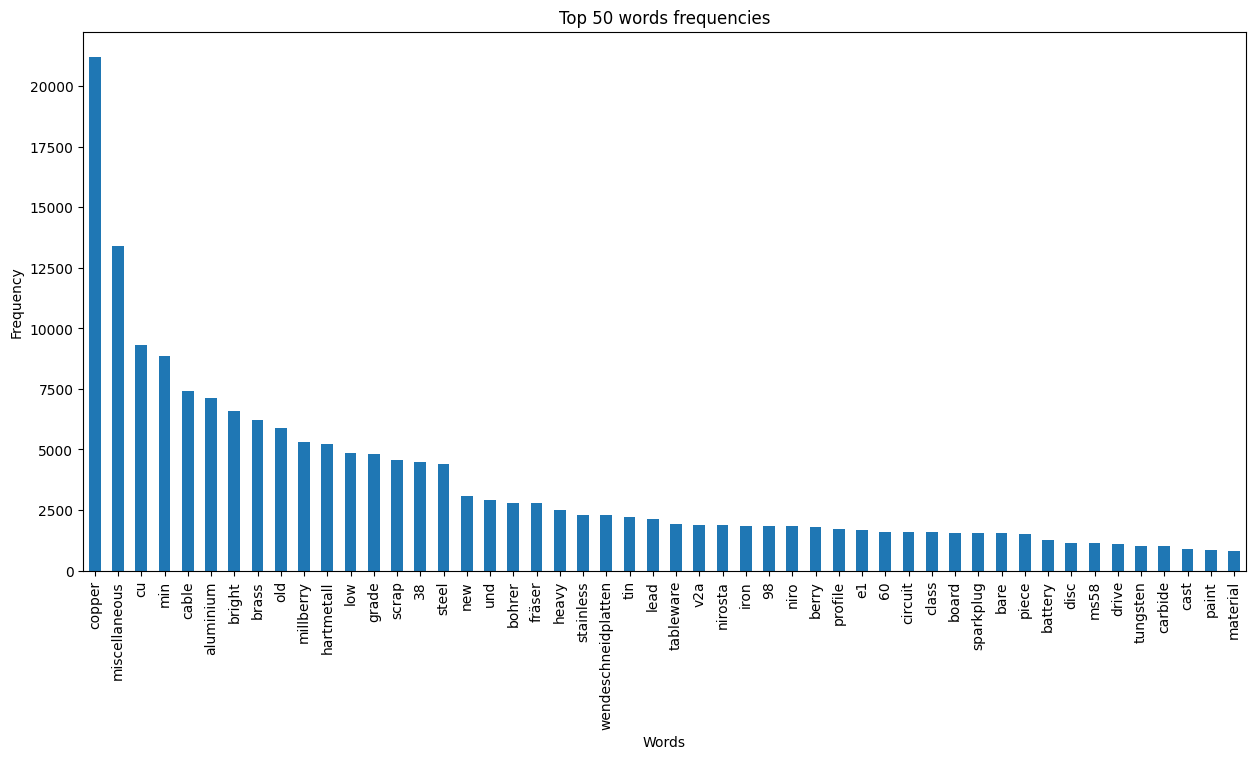

In [34]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer object
vectorizer = CountVectorizer()

corpus = df1['p_ds_material_alias'].values

# Generate matrix of word vectors
bow_matrix = vectorizer.fit_transform(corpus)

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray())

# Map the column names to vocabulary 
bow_df.columns = vectorizer.get_feature_names_out()

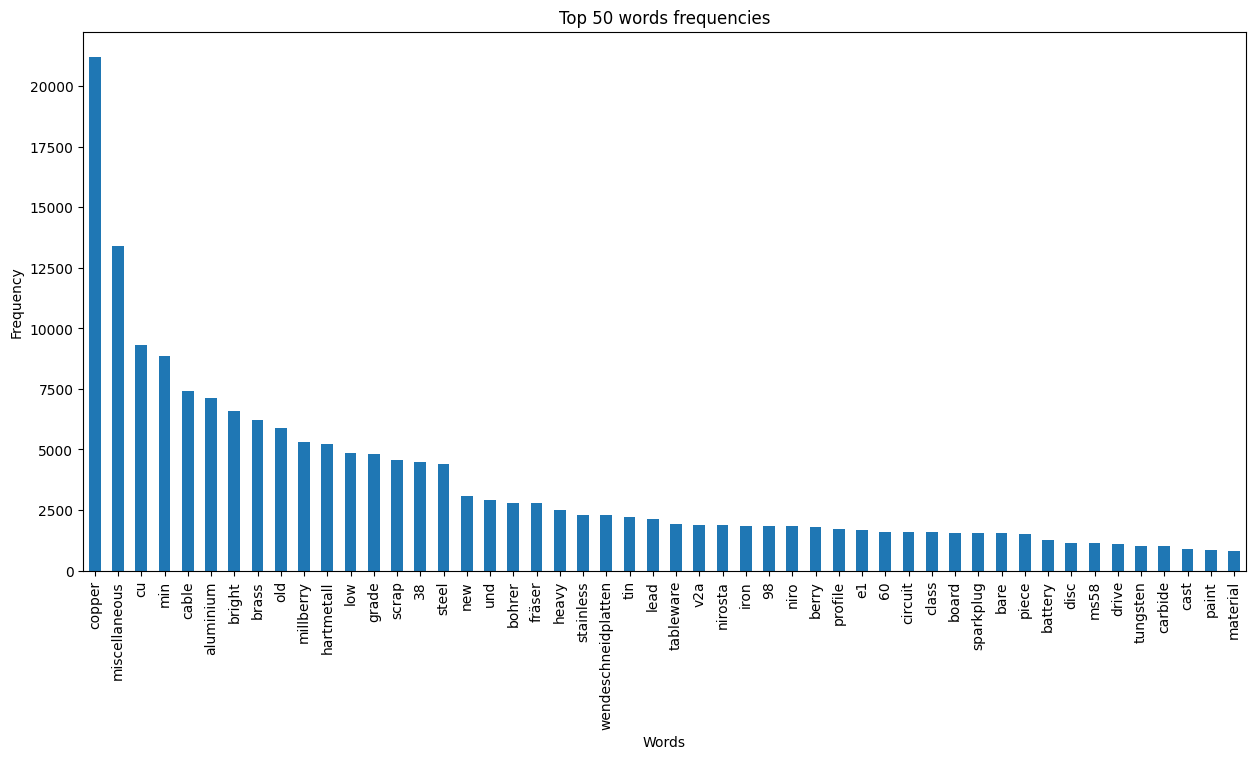

In [35]:
# Plot top 50 words frequencies
import matplotlib.pyplot as plt

# Sum the frequencies of each word
word_freq = bow_df.sum()

# Plot the top 50 words
word_freq.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(15, 7))
plt.title('Top 50 words frequencies')
plt.ylabel('Frequency')
plt.xlabel('Words')
plt.show()


In [ ]:
# Create a MultinomialNB object
clf = MultinomialNB()

# Fit the classifier
clf.fit(X_train_bow, y_train)

# Measure the accuracy
accuracy = clf.score(X_test_bow, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

# Predict the sentiment of a negative review
review = "The movie was terrible. The music was underwhelming and the acting mediocre."
prediction = clf.predict(vectorizer.transform([review]))[0]
print("The sentiment predicted by the classifier is %i" % (prediction))

# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Generate matrix of word vectors
tfidf_matrix = vectorizer.fit_transform(ted)

# Print the shape of tfidf_matrix
print(tfidf_matrix.shape)

## Calculating the cosine similarity

# Initialize an instance of tf-idf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Generate the tf-idf vectors for the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Compute and print the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

In [ ]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words='english')

# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(transcripts)

# Generate the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix1)

# Generate mapping between titles and index
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

def get_recommendations(title, cosine_sim, indices):
    # Get index of movie that matches title
    idx = indices[title]
    # Sort the movies based on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar movies
    sim_scores = sim_scores[1:11]
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

Get materials and all of the unique descriptions

In [47]:
import psycopg2
import pandas as pd
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Postgres credentials
dbname = "schrott24-live"
user = os.getenv("PG_USER")
password = os.getenv("PG_PASSWORD")
host = os.getenv("PG_HOST")
port = "5432"

# Create connection with Postgres
connection = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host,
    port=port
)

# Create a cursor
cursor = connection.cursor()

# Get query from file
with open("queries/text_query.sql", "r") as file:
    query = file.read()

# Execute the query
cursor.execute(query)

# Fetch all the rows from the result set
rows = cursor.fetchall()

# Define column names based on the table structure (optional)
column_names = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame from the query results
material_desc_df = pd.DataFrame(rows, columns=column_names)

# Close the cursor and connection
cursor.close()
connection.close()


We should create word embeddings for the different forms of metals. For instance:
Kupfer, Copper, Cu should all be the same concept. --> Would increase the performance of the model without the need of so much data

In [48]:
material_desc_df

,product_id,text
0,30020,Chapas de aluminio puro revestido (serie 1000)
1,10116,Granulado de plomo
2,10211,NEW PURE ALUMINUM WIRE AND CABLE
3,600211,Cu Giessdraht
4,30012,Chapas desnudas de AlMg (serie 5000)
...,...,...
2214,600084,Clean copper foil
2215,600118,Aluminium offset with paper attachment on the ...
2216,27735,AlMgSi0.5 - bare aluminium punchings
2217,18025,Millberry


In [52]:
# Import train_test_split

from sklearn.model_selection import train_test_split

X = material_desc_df.drop('product_id', axis=1)
y = material_desc_df['product_id']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [66]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer()

# Corpus
corpus_orig = material_desc_df['text'].to_list()

# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(corpus)

# Generate the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

# Generate mapping between titles and index
indices = pd.Series(material_desc_df.index, index=material_desc_df['product_id']).drop_duplicates()

# Create function to return top n matches
def get_top_n_matches(material, cosine_sim, indices, n=10):
    # Add new material to corpus
    corpus = corpus_orig.append(material)
    # Construct the TF-IDF matrix
    tfidf_matrix = tfidf.fit_transform(corpus)
    # Generate the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)
    # Order the results by similarity
    sim_scores = list(enumerate(cosine_sim[-1]))



In [132]:
# Read the query from the query file    
queries_path = os.path.join(os.getcwd(), "queries/")

# Read the cart items query
query = open(queries_path + "materials.sql").read()

# Get cart_items
materials = get_df_from_databricks(query)

# Change product_id to int
materials['product_id'] = materials['product_id'].astype(int)

In [150]:
# Saving the data as to not query it again
path = os.path.join(os.getcwd(), "data/")
materials.to_csv(path + 'materials.csv', index=False)
material_desc_df.to_csv(path + 'material_desc.csv', index=False)

In [148]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer()

# Corpus
corpus = material_desc_df['text'].to_list()

# Material to test
material = 'Copper milb'

# Add new material to corpus
corpus.append(material)
# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(corpus)
# Generate the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

# Get scores of the last material
sim_scores = list(enumerate(cosine_sim[-1]))

# Sort the materials based on the similarity scores
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

# Get the scores for 10 most similar materials
sim_scores = sim_scores[1:11]

# Get the material indices
material_indices = [i[0] for i in sim_scores]

# Return the top 10 most similar materials
top_n_scores = material_desc_df['product_id'].iloc[material_indices]

# Create DataFrame with top 10 most similar materials and their scores
top_n_scores_df = pd.DataFrame({'product_id': top_n_scores, 'similarity_score': [i[1] for i in sim_scores]})

# Merge with materials DataFrame to get material details
result = pd.merge(top_n_scores_df, materials, on='product_id')

result

,product_id,similarity_score,material_name,material_category,default_english_alias
0,600215,0.196438,"Copper, copper 99.9%, Sheets, Clean",Copper,Cathode
1,31082,0.181091,"Copper, Copper chromium, Solids, Clean",Copper,CuCr1Zr (CW106C)
2,600211,0.178710,"Copper, copper 99.9%, Rod , Clean",Copper,Copper Rod
3,18009,0.172817,"Alu-Kühler, rein",Aluminium,"Aluminium-copper, clean"
4,18024,0.172350,"Kupfer, gemischt, Raff, alt",Copper,"Copper, miscellaneous, low-grade, old"
5,600096,0.169994,"Copper, copper 99.9%, Wire, Lacquered",Copper,copper enamelled wire with paper
6,18067,0.163364,"Copper, MS58, Solids, Clean",Red brass,Copper alloy
7,10198,0.162806,Rotguss GBZ,Red brass,Tombac GBZ
8,10089,0.160250,Kupfer Späne,Copper,Copper turnings
9,600200,0.157339,"Copper, Berry - 99.8% Cu, Foil, Clean",Copper,Copper 99.8%


In [ ]:
path = os.path.join(os.getcwd(), "data/")

# Load the data
materials = pd.read_csv(path + 'materials.csv')
material_desc_df = pd.read_csv(path + 'material_desc.csv')

# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer()

# Corpus
corpus = material_desc_df['text'].to_list()

# Material to test
material = 'Copper milb'

# Add new material to corpus
corpus.append(material)
# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(corpus)
# Generate the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

# Get scores of the last material
sim_scores = list(enumerate(cosine_sim[-1]))

# Sort the materials based on the similarity scores
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

# Get the scores for 10 most similar materials
sim_scores = sim_scores[1:11]

# Get the material indices
material_indices = [i[0] for i in sim_scores]

# Return the top 10 most similar materials
top_n_scores = material_desc_df['product_id'].iloc[material_indices]

# Create DataFrame with top 10 most similar materials and their scores
top_n_scores_df = pd.DataFrame({'product_id': top_n_scores, 'similarity_score': [i[1] for i in sim_scores]})

# Merge with materials DataFrame to get material details
result = pd.merge(top_n_scores_df, materials, on='product_id')

result